# Feedforward Neural Network

## Imports and Loading Dataset

In [1]:
!pip install numpy pandas matplotlib seaborn scikit-learn torch platform psutil getpass


ERROR: Could not find a version that satisfies the requirement platform (from versions: none)
ERROR: No matching distribution found for platform


In [2]:
import platform
import psutil
import getpass

# --- Setup: Imports ---
import os, seaborn, sklearn, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim

# Scikit-learn imports
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.utils import shuffle
def print_system_info():
    print("="*60)
    print("SYSTEM INFORMATION")
    print("="*60)


    print(f"Operating System : {platform.system()} {platform.release()}")
    print(f"Processor        : {platform.processor()}")
    print(f"CPU Cores        : {psutil.cpu_count(logical=True)}")
    print(f"RAM              : {round(psutil.virtual_memory().total / (1024**3), 2)} GB")


    print(f"PC Username      : {getpass.getuser()}")


    print(f"Python Version   : {platform.python_version()}")
    print(f"Working Dir      : {os.getcwd()}")


    if torch.cuda.is_available():
        print(f"GPU Device       : {torch.cuda.get_device_name(0)}")
        print(f"CUDA Version     : {torch.version.cuda}")
    else:
        print("GPU Device       : None (CPU mode)")

    print("="*60)
    print()

print_system_info()


random_seed = 11
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

df = pd.read_csv('dataset/dataset_csv/JM1.csv')

SYSTEM INFORMATION
Operating System : Darwin 23.6.0
Processor        : arm
CPU Cores        : 8
RAM              : 8.0 GB
PC Username      : mason
Python Version   : 3.12.12
Working Dir      : /Users/mason/4ML3/Bonus Project
GPU Device       : None (CPU mode)



## Formatting Data

In [3]:
raw_features = df.iloc[:, :-1].values.astype(float)



X = raw_features

# X = (raw_features - raw_features.min(axis=0)) / (raw_features.max(axis=0) - raw_features.min(axis=0))
y = df.iloc[:,-1].apply(lambda x: 1 if str(x) == 'Y' else 0).values

test_ratio = 0.2
seed = 1 
n = y.shape[0]
rng = np.random.default_rng(seed)
idx = np.arange(n)
rng.shuffle(idx)
n_val = int(round(test_ratio * n))
val_idx = idx[:n_val]
train_idx = idx[n_val:]

x_train = X[train_idx]
x_val = X[val_idx]
y_train = y[train_idx]
y_val = y[val_idx]


scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_val = scaler.fit_transform(x_val)

X_train_t = torch.Tensor(X_train)
X_val_t = torch.Tensor(X_val)


print(f"Training features shape: {X_train_t.shape}")
print(f"Validation features shape: {X_val_t.shape}")


Training features shape: torch.Size([6176, 21])
Validation features shape: torch.Size([1544, 21])


## Model

In [13]:
class Net(nn.Module):

    def __init__(self, input_size,dropout_rate):
        super(Net, self).__init__()
        self.dropout_rate = dropout_rate
        self.input_size = input_size

        self.fc1 = nn.Linear(self.input_size, 32)

        self.fc2 = nn.Linear(32, 16)

        self.fc3 = nn.Linear(16,1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout()
        


    def forward(self, x):

        l1 = self.fc1(x)
        r1 = self.relu(l1)
        d1 = self.dropout(r1)


        l2 = self.fc2(d1)
        r2 = self.relu(l2)
        d2 = self.dropout(r2)
   

        output = self.fc3(d2)
        #output = self.sigmoid(l3)


        
        return output
    
input_features = X_train_t.shape[1]
print(f"Model will accept {input_features} input features.")
print("--- 3. Model Class Defined ---")


Model will accept 21 input features.
--- 3. Model Class Defined ---


In [5]:
def calculate_full_loss(model, criterion, X, y):
    """Helper function to calculate loss over an entire dataset."""
    model.eval() # Set model to evaluation mode
    with torch.no_grad(): # Disable gradient calculation
        outputs = model(X)
        loss = criterion(outputs, y)
    model.train() # Set model back to train mode
    return loss.item()

def train_with_minibatch(model, criterion, optimizer, X_train, y_train, X_val, y_val,
                         num_iterations, batch_size, check_every, l1_lambda):


    best_v_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    iterations = []
    num_samples = X_train.shape[0]
    current_iteration = 0
    X_train_shuffled = X_train.clone()
    y_train_shuffled = y_train.clone()
    

    for i in range(num_iterations):
        if current_iteration+batch_size > num_samples:
            
            X_train_np, y_train_np = shuffle(X_train_shuffled.numpy(), y_train_shuffled.numpy())
            X_train_shuffled = torch.tensor(X_train_np, dtype=torch.float32)
            y_train_shuffled = torch.tensor(y_train_np, dtype=torch.float32)
            current_iteration = 0 
        
        
        xt_batch = X_train_shuffled[current_iteration : current_iteration+ batch_size]
        yt_batch = y_train_shuffled[current_iteration : current_iteration+ batch_size]

        current_iteration+=batch_size
        l1_norm = sum(p.abs().sum() for p in model.parameters())

        model.train()
        optimizer.zero_grad()
        t_pred = model(xt_batch)
        t_loss = criterion(t_pred,yt_batch) + l1_lambda*l1_norm
        t_loss.backward()
        optimizer.step()
        if i%check_every == 0:
            current_v_loss = calculate_full_loss(model,criterion, X_val, y_val)
            current_t_loss = calculate_full_loss(model,criterion, X_train, y_train)
            train_losses.append(current_t_loss)
            val_losses.append(current_v_loss)
            iterations.append(i)


    return train_losses, val_losses, iterations, model 

In [6]:
def calculate_accuracy(model, X, y):

    model.eval()

    with torch.no_grad():

        outputs = model(X) 
        outputs = torch.sigmoid(outputs)
        predictions = (outputs>=0.5).float() 
        accuracy = (predictions == y).float().mean() 

    return accuracy

In [ ]:

LAMBDA_L1_LIST = [0.0001]
LEARNING_RATE_L1 = 0.01
NUM_ITERATIONS_L1 = 300000
BATCH_SIZE_L1 = 64
CHECK_EVERY_L1 = 100
dropout_rate = 0.5

for LAMBDA_L1 in LAMBDA_L1_LIST:
    print(f"\n--- Training with L1 λ = {LAMBDA_L1} ---")
        
    y_train_t = torch.tensor(y_train).view(-1,1).float()
    y_val_t = torch.tensor(y_val).view(-1,1).float()
    num_pos= y_train.sum()
    num_neg = len(y_train)-num_pos
    pos_weight = num_pos/num_neg
    pos_weight_tensor = torch.tensor([pos_weight], dtype=torch.float32)

    model_l1 = Net(input_size=input_features,dropout_rate=dropout_rate)

    weight_1 = num_neg / num_pos # Scale up the minority class

    weight = torch.tensor(weight_1, dtype=torch.float32)

    criterion = nn.BCEWithLogitsLoss(weight=weight)
    optimizer_l1 =  torch.optim.SGD(model_l1.parameters(), lr=LEARNING_RATE_L1)


    train_losses_l1, val_losses_l1, iterations_l1, model= train_with_minibatch(
        model_l1, criterion, optimizer_l1,
        X_train_t, y_train_t, X_val_t, y_val_t,
        NUM_ITERATIONS_L1, BATCH_SIZE_L1, CHECK_EVERY_L1, LAMBDA_L1
    )

    final_accuracy_l1 = calculate_accuracy(model,X_val_t,y_val_t)

    print(f"Final Validation Accuracy (L1): {final_accuracy_l1*100:.2f}%")


--- Training with L1 λ = 0.0001 ---
Final Validation Accuracy (L1): 79.40%


### Feature Importance (L1 Sparsity Check) 
Metric Name | Total Weight Magnitude | Status 
 | :--- | :--- | :--- 
| LOC_BLANK | 0.1589 | Active Feature
| NUM_UNIQUE_OPERATORS | 0.1146 | Active Feature
| LOC_CODE_AND_COMMENT | 0.0899 | Active Feature
| HALSTEAD_DIFFICULTY | 0.0739 | Active Feature
| ESSENTIAL_COMPLEXITY | 0.0623 | Active Feature
| BRANCH_COUNT | 0.0589 | Active Feature
| LOC_COMMENTS | 0.0538 | Active Feature
| DESIGN_COMPLEXITY | 0.0516 | Active Feature
| NUM_UNIQUE_OPERANDS | 0.0463 | Active Feature
| LOC_EXECUTABLE | 0.0445 | Active Feature
| HALSTEAD_CONTENT | 0.0396 | Active Feature
| CYCLOMATIC_COMPLEXITY | 0.0372 | Active Feature
| NUM_OPERANDS | 0.0354 | Active Feature
| NUM_OPERATORS | 0.0322 | Active Feature
| LOC_TOTAL | 0.0315 | Active Feature
| HALSTEAD_LEVEL | 0.0252 | Active Feature
| HALSTEAD_LENGTH | 0.0133 | Active Feature
| HALSTEAD_VOLUME | 0.0090 | Active Feature
| HALSTEAD_ERROR_EST | 0.0081 | Active Feature
| HALSTEAD_PROG_TIME | 0.0070 | Active Feature
| HALSTEAD_EFFORT | 0.0068 | Active Feature


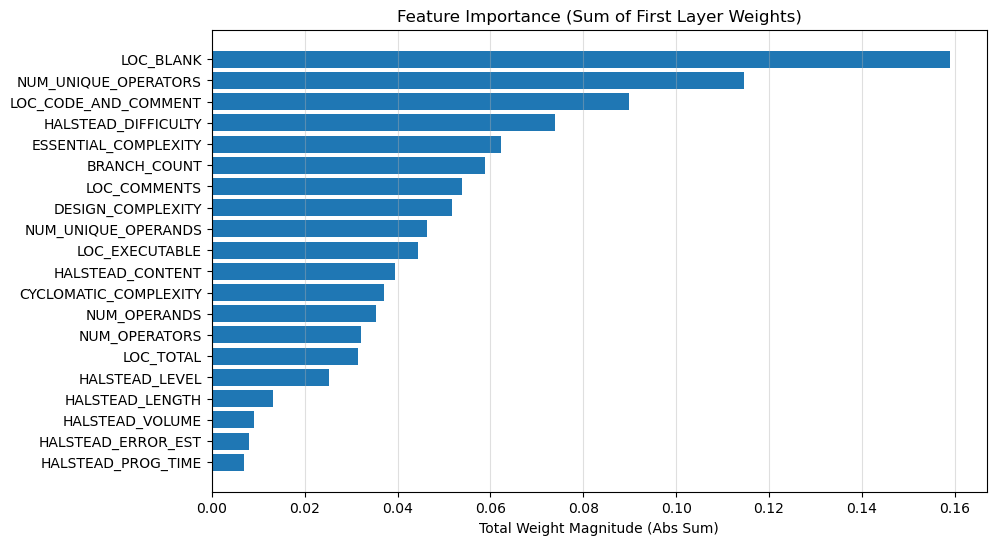

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown


first_layer_weights = next(model.parameters()).data.cpu()


weights = torch.sum(torch.abs(first_layer_weights), dim=0).numpy()

standard_weights = weights/(sum(weights)+1e-9)
feature_names = df.columns[:-1] 


importance = sorted(list(zip(feature_names, standard_weights)), key=lambda x: x[1], reverse=True)


md_table = '### Feature Importance (L1 Sparsity Check) \n'
md_table += 'Metric Name | Total Weight Magnitude | Status \n'
md_table += ' | :--- | :--- | :--- \n'

for name, weight in importance:

    
    if weight < 1e-3:
        impact = 'Pruned (Little Impact)' 
    else:
        impact = 'Active Feature'
        
    md_table += f"| {name} | {weight:.4f} | {impact}\n"

display(Markdown(md_table))

names_sorted = [name for name, _ in importance]
weights_sorted = [weight for _, weight in importance]

plt.figure(figsize=(10, 6))
plt.title('Feature Importance (Sum of First Layer Weights)')
plt.xlabel("Total Weight Magnitude (Abs Sum)")
plt.grid(axis='x', alpha=0.4)


top_n = 20 
plt.barh(names_sorted[:top_n][::-1], weights_sorted[:top_n][::-1])
plt.show()